Если после запуска первых 2 ячеек все равно вылезает ошибка, при попытке загрузки библиотек, то надо перезагрузить среду и запустить ячейку с библиотеками еще раз.

In [1]:
!pip install --upgrade --force-reinstall numpy gensim
from IPython import display
display.clear_output()

In [2]:
!pip install pymorphy3
from IPython import display
display.clear_output()

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from IPython import display
import pymorphy3
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from torch.nn.utils.rnn import pad_sequence
import random
from transformers import BertTokenizer, BertModel

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"semga1337","key":"71ad53ae3510851a09ee86c395e0a92b"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competiti1ons download -c dl-2025-study-competition-2
!unzip dl-2025-study-competition-2.zip

usage: kaggle [-h] [-v] [-W]
              {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
              ...
kaggle: error: argument command: invalid choice: 'competiti1ons' (choose from 'competitions', 'c', 'datasets', 'd', 'kernels', 'k', 'models', 'm', 'files', 'f', 'config')
Archive:  dl-2025-study-competition-2.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## ПУНКТ 1: Проанализировать данные, посмотреть на баланс классов, посмотреть на представителей классов, поизучать текста, сделать выводы.

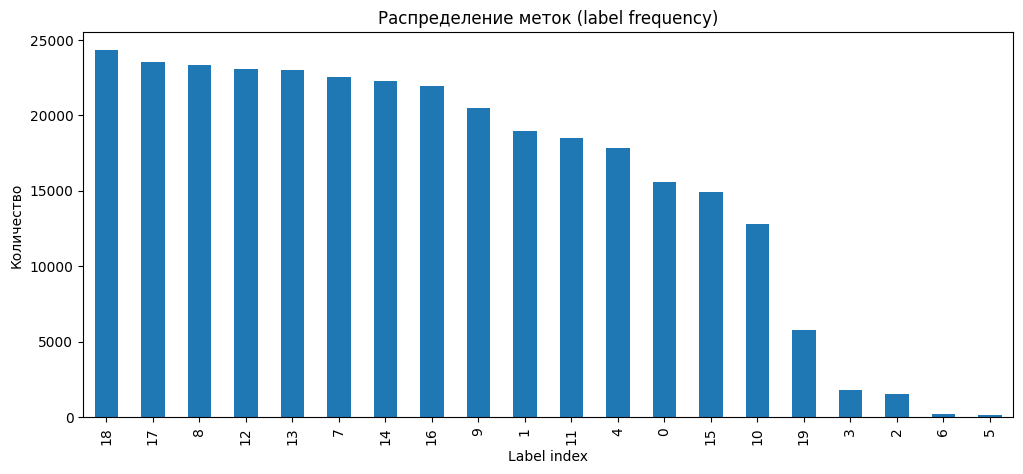

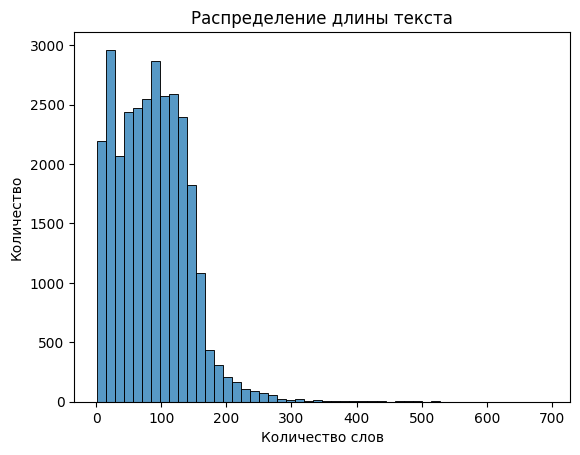

Пример текста:
Comedylesque
🏛
Ночной клуб «Гештальт»
📍
Милютинский переулок, 15с2А, м. Тургеневская
🗓
25 мая (сб) 19:00, сбор гостей с 18:00
🎫
Билеты от 1800р. по ссылке
💚
-10% по промокоду ШОУ
Comedylesque — это шоу, которое объединило в себе три направления: стендап, бурлеск и живой вокал. Звёзды бурлеска сделают ваш вечер ярким и полным блеска, стендап-комики приправят вечер искромётными шутками, а джаз-вокал придаст мероприятию бархатистости.
Искусно соединив три жанра в одном, мы даём зрителям возможность попасть на уникальное шоу - одновременно самое горячее и самое смешное!
Сбор гостей за час до начала программы. Ожидание начала представления будет скрашивать живой вокал и приветственный бокал игристого. Стоимость закусок и напитков не входит в стоимость билета.
Dress Code: Вечер будет ярким и красивым, мы будем рады видеть вас нарядными.
🥰
Билеты со скидками
@teatr_msk

Метки:
[0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0]


In [ ]:
train = pd.read_csv("train.csv")
train["labels"] = train["labels"].apply(lambda x: list(map(int, x.strip().split())))
labels_df = pd.DataFrame(train["labels"].to_list())
label_counts = labels_df.sum().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
label_counts.plot(kind="bar")
plt.title("Распределение меток")
plt.xlabel("Label index")
plt.ylabel("Количество")
plt.show()

train["text_len"] = train["text"].apply(lambda x: len(x.split()))
sns.histplot(train["text_len"], bins=50)
plt.title("Распределение длины текста")
plt.xlabel("Количество слов")
plt.ylabel("Количество")
plt.show()

print("Пример текста:")
print(train.loc[6627, "text"])
print("\nМетки:")
print(train.loc[6627, "labels"])

In [ ]:
train = pd.read_csv("train.csv")
train["labels"] = train["labels"].apply(lambda x: list(map(int, x.strip().split())))
labels_df = pd.DataFrame(train["labels"].to_list())

# Общая статистика
print("=== Общая статистика ===")
print(f"Всего примеров: {len(train)}")
print(f"Количество меток на пример: {labels_df.sum(axis=1).mean():.2f} ± {labels_df.sum(axis=1).std():.2f}")
print(f"Максимум меток в одном примере: {labels_df.sum(axis=1).max()}")
print(f"Минимум меток в одном примере: {labels_df.sum(axis=1).min()}\n")

# Статистика по меткам
label_counts = labels_df.sum(axis=0)
print("=== Статистика по меткам ===")
print(f"Всего активаций меток: {label_counts.sum()}")
print(f"Самый частый класс (idx {label_counts.idxmax()}): {label_counts.max()} активаций ({label_counts.max()/len(train)*100:.1f}%)")
print(f"Самый редкий класс (idx {label_counts.idxmin()}): {label_counts.min()} активаций ({label_counts.min()/len(train)*100:.1f}%)\n")

train['word_count'] = train['text'].apply(lambda x: len(x.split()))
train['char_count'] = train['text'].apply(len)
print("=== Статистика длины текстов ===")
print(train['word_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.95]))
print(f"\nДлина текста (символы): {train['char_count'].mean():.0f} ± {train['char_count'].std():.0f}")

plt.figure(figsize=(10, 6))
sns.histplot(train['word_count'], bins=50)
plt.title('Распределение длины текстов (в словах)')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.savefig('text_length_distribution.png')
plt.close()

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
X = vectorizer.fit_transform(train['text'])
all_words = vectorizer.get_feature_names_out()
word_counts = X.sum(axis=0).A1
word_freq = dict(zip(all_words, word_counts))

print("\n=== Лексический анализ ===")
print(f"Уникальных слов: {len(word_freq)}")
print(f"20 самых частых слов: {sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]}")

# Type-Token Ratio
ttr = len(word_freq) / sum(word_counts)
print(f"Type-Token Ratio: {ttr:.3f}")

train['emoji_count'] = train['text'].apply(lambda x: len(re.findall(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF]', x)))
train['hashtag_count'] = train['text'].apply(lambda x: len(re.findall(r'#\w+', x)))
train['mention_count'] = train['text'].apply(lambda x: len(re.findall(r'@\w+', x)))
train['url_count'] = train['text'].apply(lambda x: len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', x)))

print("\n=== Специальные символы ===")
print(f"Текстов с эмодзи: {(train['emoji_count'] > 0).sum()} ({(train['emoji_count'] > 0).mean()*100:.1f}%)")
print(f"Среднее эмодзи на текст: {train['emoji_count'].mean():.1f}")
print(f"Текстов с хештегами: {(train['hashtag_count'] > 0).sum()} ({(train['hashtag_count'] > 0).mean()*100:.1f}%)")
print(f"Текстов с упоминаниями: {(train['mention_count'] > 0).sum()} ({(train['mention_count'] > 0).mean()*100:.1f}%)")
print(f"Текстов с URL: {(train['url_count'] > 0).sum()} ({(train['url_count'] > 0).mean()*100:.1f}%)\n")

print("=== Связь длины текста и меток ===")
for i in range(20):
    mean_len = train.loc[labels_df[i] == 1, 'word_count'].mean()
    print(f"Метка {i}: средняя длина {mean_len:.1f} слов")

=== Общая статистика ===
Всего примеров: 29568
Количество меток на пример: 10.57 ± 2.28
Максимум меток в одном примере: 16
Минимум меток в одном примере: 4

=== Статистика по меткам ===
Всего активаций меток: 312471
Самый частый класс (idx 18): 24300 активаций (82.2%)
Самый редкий класс (idx 5): 99 активаций (0.3%)

=== Статистика длины текстов ===
count    29568.000000
mean        86.606196
std         54.477555
min          1.000000
25%         44.000000
50%         85.000000
75%        122.000000
95%        170.000000
max        694.000000
Name: word_count, dtype: float64

Длина текста (символы): 605 ± 380

=== Лексический анализ ===
Уникальных слов: 115373
20 самых частых слов: [('в', 82081), ('и', 81262), ('на', 42487), ('00', 33363), ('по', 33151), ('с', 25452), ('билеты', 20006), ('19', 14324), ('https', 12909), ('для', 12070), ('не', 11701), ('от', 11578), ('20', 11456), ('30', 11093), ('а', 10052), ('промокоду', 9774), ('со', 9468), ('из', 8590), ('до', 8527), ('спектакль', 82

Выводы:

1) Объем данных:

29,568 текстов, каждый содержит от 4 до 16 меток (в среднем 10.6 ± 2.3).
Дисбаланс меток: Самый частый класс (idx 18): 82.2% текстов.
Самый редкий класс (idx 5): всего 0.3% (99 активаций).
Проблема: Крайний дисбаланс требует использования F1-score (macro/micro) и методов вроде взвешенного loss или oversampling.

2) Длина текстов:

Средняя длина: 87 слов (медиана — 85), но есть выбросы до 694 слов. 95% текстов короче 170 слов.

3) Лексика и спецсимволы:

Уникальных слов 115,373 (высокое разнообразие). Частые слова: предлоги ("в", "на"), время ("00", "19"), маркетинг ("билеты", "промокоду"). Эмодзи: 63.5% текстов (в среднем 2.8 на текст). Хештеги (24.8%), упоминания (40.4%), URL (30.3%).

4) Связь меток и длины текста:

Короткие тексты (19–40 слов): метки 3, 15, 19 (возможно, формальные анонсы).
Длинные тексты (>100 слов): метки 1, 5, 6, 10 (детальные описания событий).



## 2 ПУНКТ: Проанализировать, какие очистки текста необходимы под разные способы токенизации и задания эмбеддингов для этой задачи: (1) tf-idf + любая нейронная сеть; (2) w2v + любая нейронная сеть; (3) встроенный эмбеддинг в нейросетевое решение на свёрточных сетях; (4) встроенный эмбеддинг в нейросетевое решение на рекуррентных сетях; (5) эмбеддер + решение на bert-like моделях (любой вид). Создать пайплайны очистки текста и очистить.

In [6]:
nltk.download('stopwords')
morph = pymorphy3.MorphAnalyzer()
stopwords_ru = set(stopwords.words("russian"))

# Функция лемматизации
def lemmatize_text(text):
    tokens = text.split()
    lemmas = [morph.parse(token)[0].normal_form for token in tokens]
    return " ".join(lemmas)

# 1. TF-IDF + Нейронная сеть
def clean_text_tfidf(text):
    text = text.lower()
    text = re.sub(r'[^a-zа-яё\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stopwords_ru and len(w) > 2]
    text = " ".join(tokens)
    text = lemmatize_text(text)
    return text

# 2. Word2Vec + Нейронная сеть
def clean_text_w2v(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 3. Встроенный эмбеддинг + CNN
def clean_text_cnn(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[\r\n\t]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 4. Встроенный эмбеддинг + RNN
def clean_text_rnn(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[\r\n\t]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 5. Эмбеддинг + BERT-like модель
def clean_text_bert(text):
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[\r\n\t]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
tqdm.pandas()
train = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
test_data = pd.read_csv('test.csv')

# Словарь функций очистки
cleaning_functions = {
    'tfidf': clean_text_tfidf,
    'w2v': clean_text_w2v,
    'cnn': clean_text_cnn,
    'rnn': clean_text_rnn,
    'bert': clean_text_bert
}

# Применяем каждую функцию и сохраняем в новый столбец с прогресс-баром
for name, func in cleaning_functions.items():
    print(f"Применяется очистка для: {name.upper()}")
    train[f'text_clean_{name}'] = train['text'].progress_apply(func)


Применяется очистка для: TFIDF


  0%|          | 0/29568 [00:00<?, ?it/s]

Применяется очистка для: W2V


  0%|          | 0/29568 [00:00<?, ?it/s]

Применяется очистка для: CNN


  0%|          | 0/29568 [00:00<?, ?it/s]

Применяется очистка для: RNN


  0%|          | 0/29568 [00:00<?, ?it/s]

Применяется очистка для: BERT


  0%|          | 0/29568 [00:00<?, ?it/s]

## 3 ПУНКТ: Поделить данные на трейн-валидацию, обучить все модели из п.2. Снабдить обучение моделей графиками отрисовки лосей и метрик, шедулерами, свитч лосей (метрик), сохранение лучшей модели, ранней остановкой, вормапом.

In [8]:
min_samples_per_class = 2
label_counts = train['labels'].value_counts()
valid_labels = label_counts[label_counts >= min_samples_per_class].index
train = train[train['labels'].isin(valid_labels)].reset_index(drop=True)

test_size = 0.2

# TF-IDF
train_tfidf, val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(
    train['text_clean_tfidf'],
    train['labels'],
    test_size=test_size,
    stratify=train['labels']
)

# Word2Vec
train_w2v, val_w2v, y_train_w2v, y_val_w2v = train_test_split(
    train['text_clean_w2v'],
    train['labels'],
    test_size=test_size,
    stratify=train['labels']
)

# CNN
train_cnn, val_cnn, y_train_cnn, y_val_cnn = train_test_split(
    train['text_clean_cnn'],
    train['labels'],
    test_size=test_size,
    stratify=train['labels']
)

# RNN
train_rnn, val_rnn, y_train_rnn, y_val_rnn = train_test_split(
    train['text_clean_rnn'],
    train['labels'],
    test_size=test_size,
    stratify=train['labels']
)

# BERT
train_bert, val_bert, y_train_bert, y_val_bert = train_test_split(
    train['text_clean_bert'],
    train['labels'],
    test_size=test_size,
    stratify=train['labels']
)

In [9]:
threshold = 0.5

# Возможные функции потерь
LOSS_OPTIONS = {
    'bce': nn.BCELoss(),
    'bce_logits': nn.BCEWithLogitsLoss(),
}

# Метрики для оценки
def f1_macro_metric(y_true, y_pred, thresh=threshold):
    y_pred_bin = (y_pred > thresh).astype(int)
    return f1_score(y_true, y_pred_bin, average='macro')

def accuracy_metric(y_true, y_pred, thresh=threshold):
    y_pred_bin = (y_pred > thresh).astype(int)
    return accuracy_score(y_true, y_pred_bin)

def roc_auc_metric(y_true, y_pred, thresh=None):
    try:
        return roc_auc_score(y_true, y_pred, average='macro')
    except ValueError:
        return 0.0

METRIC_OPTIONS = {
    'f1_macro': f1_macro_metric,
    'accuracy': accuracy_metric,
    'roc_auc': roc_auc_metric,
}

Модель:tf-idf + нейронка

Epoch 1: Train Loss=0.3408, Val Loss=0.2520, Train f1_macro=0.6823, Val f1_macro=0.7413
Epoch 2: Train Loss=0.2307, Val Loss=0.2161, Train f1_macro=0.7542, Val f1_macro=0.7636
Epoch 3: Train Loss=0.1922, Val Loss=0.2010, Train f1_macro=0.7862, Val f1_macro=0.7978
Epoch 4: Train Loss=0.1656, Val Loss=0.1928, Train f1_macro=0.8203, Val f1_macro=0.8155
Epoch 5: Train Loss=0.1448, Val Loss=0.1921, Train f1_macro=0.8417, Val f1_macro=0.8332
Epoch 6: Train Loss=0.1269, Val Loss=0.1924, Train f1_macro=0.8565, Val f1_macro=0.8343
Epoch 7: Train Loss=0.1141, Val Loss=0.1971, Train f1_macro=0.8712, Val f1_macro=0.8422
Epoch 8: Train Loss=0.1014, Val Loss=0.2013, Train f1_macro=0.8849, Val f1_macro=0.8434
Epoch 9: Train Loss=0.0913, Val Loss=0.2104, Train f1_macro=0.8954, Val f1_macro=0.8458
Epoch 10: Train Loss=0.0835, Val Loss=0.2171, Train f1_macro=0.9057, Val f1_macro=0.8575
Epoch 11: Train Loss=0.0763, Val Loss=0.2273, Train f1_macro=0.9179, Val f1_macro=0.8453
Epoch 12: Train Loss=0.0707, V

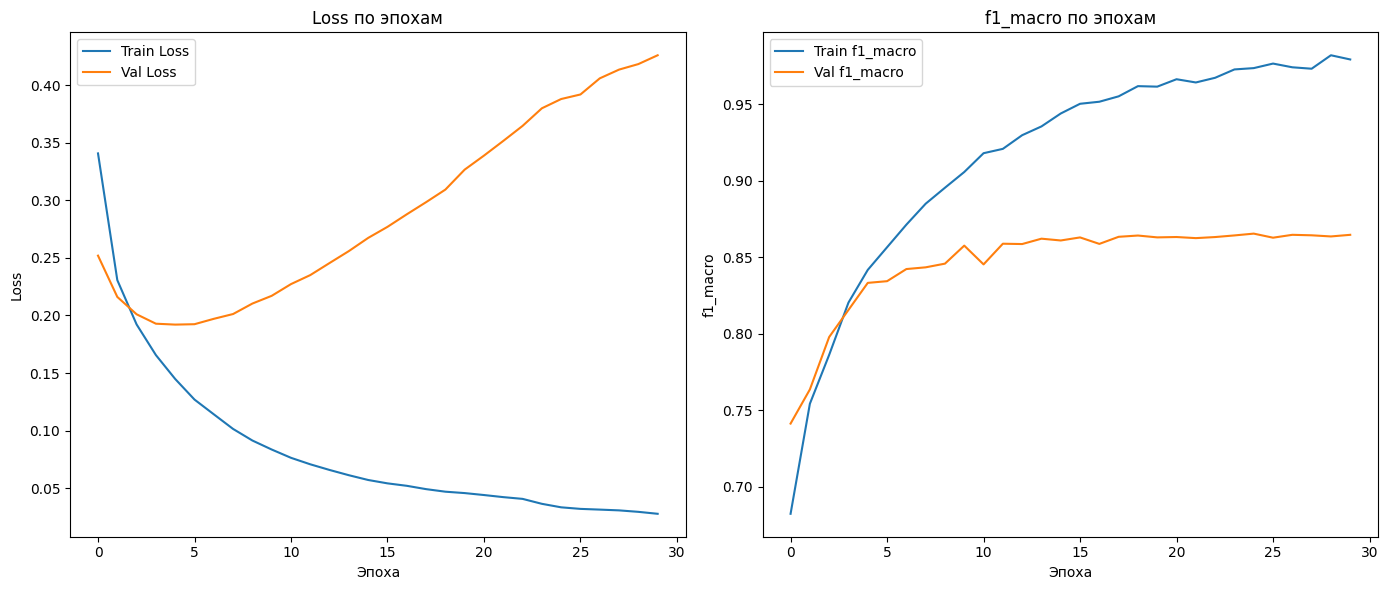

In [ ]:
# Параметры
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_df = pd.read_csv('test.csv')
batch_size = 32
num_epochs = 30
early_stop_rounds = 5
lr = 0.001
dropout_rate = 0.3
hidden_sizes = [128, 64]

# Выбор используемой функции потерь и метрики

SELECTED_LOSS = 'bce'          # 'bce' или 'bce_logits'
SELECTED_METRIC = 'f1_macro'   # 'accuracy', 'roc_auc' и f1_macro.

# Загрузка данных
def parse_label_string(label_str):
    if isinstance(label_str, str):
        return np.array([float(x) for x in label_str.split()], dtype=np.float32)
    elif isinstance(label_str, (list, np.ndarray)):
        return np.array(label_str, dtype=np.float32)
    else:
        raise ValueError(f"Неожиданный формат метки: {label_str}")


y_train_np = np.vstack(y_train_tfidf.apply(parse_label_string).values)
y_val_np = np.vstack(y_val_tfidf.apply(parse_label_string).values)

tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train = tfidf_vectorizer.fit_transform(train_tfidf).toarray()
X_val = tfidf_vectorizer.transform(val_tfidf).toarray()
X_test = tfidf_vectorizer.transform(test_df['text']).toarray()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_np, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Модель

class TFIDFNeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_sizes[0]),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_sizes[1], output_dim),
            nn.Sigmoid() if SELECTED_LOSS == 'bce' else nn.Identity()
        )
    def forward(self, x):
        return self.model(x)

num_labels = y_train_np.shape[1]
model = TFIDFNeuralNet(X_train.shape[1], num_labels).to(device)

loss_function = LOSS_OPTIONS[SELECTED_LOSS]
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

best_val_metric = -np.inf
early_stop_counter = 0

train_loss_history = []
val_loss_history = []
train_metric_history = []
val_metric_history = []

def threshold_preds(probs, thresh=threshold):
    return (probs > thresh).astype(int)

# Обучение и валидация

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    train_targets = []
    train_preds = []

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        train_targets.append(batch_y.detach().cpu().numpy())
        if SELECTED_LOSS == 'bce_logits':
            train_preds.append(torch.sigmoid(outputs).detach().cpu().numpy())
        else:
            train_preds.append(outputs.detach().cpu().numpy())

    avg_train_loss = np.mean(train_losses)
    train_targets_np = np.vstack(train_targets)
    train_preds_np = np.vstack(train_preds)
    train_metric = METRIC_OPTIONS[SELECTED_METRIC](train_targets_np, train_preds_np, thresh=threshold)

    model.eval()
    val_losses = []
    val_targets = []
    val_preds = []

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            loss = loss_function(outputs, batch_y)
            val_losses.append(loss.item())

            val_targets.append(batch_y.cpu().numpy())
            if SELECTED_LOSS == 'bce_logits':
                val_preds.append(torch.sigmoid(outputs).cpu().numpy())
            else:
                val_preds.append(outputs.cpu().numpy())

    avg_val_loss = np.mean(val_losses)
    val_targets_np = np.vstack(val_targets)
    val_preds_np = np.vstack(val_preds)
    val_metric = METRIC_OPTIONS[SELECTED_METRIC](val_targets_np, val_preds_np, thresh=threshold)

    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)
    train_metric_history.append(train_metric)
    val_metric_history.append(val_metric)

    print(f"Epoch {epoch+1}: "
          f"Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, "
          f"Train {SELECTED_METRIC}={train_metric:.4f}, Val {SELECTED_METRIC}={val_metric:.4f}")

    lr_scheduler.step(1 - val_metric)

    if val_metric > best_val_metric:
        best_val_metric = val_metric
        torch.save(model.state_dict(), 'best_tfidf_model.pt')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter > early_stop_rounds:
            print("Early stopping")
            break

# Загрузка лучшей модели

model.load_state_dict(torch.load('best_tfidf_model.pt'))
model.eval()

def preds_to_label_str(preds, thresh=threshold):
    return ' '.join(map(str, (preds > thresh).astype(int)))

predictions_list = []
with torch.no_grad():
    for batch_x in test_loader:
        outputs = model(batch_x[0].to(device))
        if SELECTED_LOSS == 'bce_logits':
            preds_np = torch.sigmoid(outputs).cpu().numpy()
        else:
            preds_np = outputs.cpu().numpy()
        for p in preds_np:
            predictions_list.append(preds_to_label_str(p))

submission = pd.DataFrame({
    'id': test_df['id'],
    'labels': predictions_list
})
assert len(submission) == len(test_df), f"Ожидается {len(test_df)} строк, получено {len(submission)}"
submission.to_csv('tfidf_predictions.csv', index=False)
print("Результаты сохранены в tfidf_predictions.csv")
print(submission.head())

# Визуализация

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Loss по эпохам')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_metric_history, label=f'Train {SELECTED_METRIC}')
plt.plot(val_metric_history, label=f'Val {SELECTED_METRIC}')
plt.xlabel('Эпоха')
plt.ylabel(SELECTED_METRIC)
plt.title(f'{SELECTED_METRIC} по эпохам')
plt.legend()

plt.tight_layout()
plt.show()


Модель: w2v + нейронка

Epoch 1: Train Loss=0.3557, Val Loss=0.2950, Train f1_macro=0.6925, Val f1_macro=0.7261
Epoch 2: Train Loss=0.3025, Val Loss=0.2793, Train f1_macro=0.7219, Val f1_macro=0.7353
Epoch 3: Train Loss=0.2894, Val Loss=0.2661, Train f1_macro=0.7301, Val f1_macro=0.7433
Epoch 4: Train Loss=0.2805, Val Loss=0.2599, Train f1_macro=0.7349, Val f1_macro=0.7474
Epoch 5: Train Loss=0.2735, Val Loss=0.2540, Train f1_macro=0.7380, Val f1_macro=0.7485
Epoch 6: Train Loss=0.2688, Val Loss=0.2481, Train f1_macro=0.7414, Val f1_macro=0.7561
Epoch 7: Train Loss=0.2642, Val Loss=0.2449, Train f1_macro=0.7440, Val f1_macro=0.7549
Epoch 8: Train Loss=0.2607, Val Loss=0.2435, Train f1_macro=0.7451, Val f1_macro=0.7570
Epoch 9: Train Loss=0.2578, Val Loss=0.2416, Train f1_macro=0.7475, Val f1_macro=0.7579
Epoch 10: Train Loss=0.2560, Val Loss=0.2374, Train f1_macro=0.7489, Val f1_macro=0.7611
Epoch 11: Train Loss=0.2528, Val Loss=0.2350, Train f1_macro=0.7501, Val f1_macro=0.7605
Epoch 12: Train Loss=0.2504, V

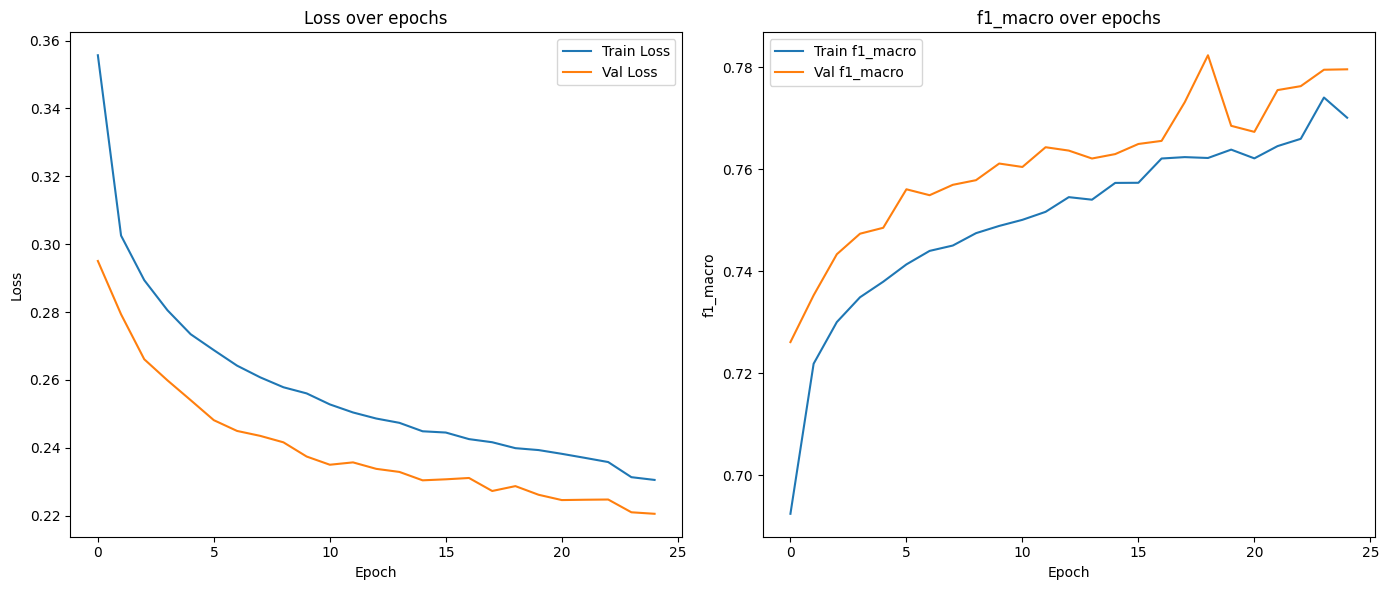

In [ ]:
# Параметры
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_df = pd.read_csv('test.csv')
batch_size = 32
num_epochs = 30
early_stop_rounds = 5
lr = 1e-3
dropout_rate = 0.3
hidden_sizes = [128, 64]

SELECTED_LOSS = 'bce'          # 'bce' или 'bce_logits'
SELECTED_METRIC = 'f1_macro'   # можно подключить метрики, я дам простой пример ниже

loss_function = LOSS_OPTIONS[SELECTED_LOSS]

#Загрузка и подготовка данных

def labels_str_to_array(label_str):
    return np.array(list(map(int, label_str.strip().split())), dtype=np.float32)

sentences = [simple_preprocess(text) for text in train_w2v]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)
embedding_dim = w2v_model.vector_size

def text_to_w2v(text, model, dim):
    words = simple_preprocess(text)
    word_vecs = [model.wv[w] for w in words if w in model.wv]
    if len(word_vecs) == 0:
        return np.zeros(dim)
    return np.mean(word_vecs, axis=0)

X_train = np.stack([text_to_w2v(text, w2v_model, embedding_dim) for text in train_w2v])
X_val = np.stack([text_to_w2v(text, w2v_model, embedding_dim) for text in val_w2v])
X_test = np.stack([text_to_w2v(text, w2v_model, embedding_dim) for text in test_df['text']])

y_train_np = np.vstack(y_train_w2v.apply(labels_str_to_array).values)
y_val_np = np.vstack(y_val_w2v.apply(labels_str_to_array).values)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_np, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Модель

class W2VNeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_sizes[0]),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_sizes[1], output_dim),
            nn.Sigmoid() if SELECTED_LOSS == 'bce' else nn.Identity()
        )

    def forward(self, x):
        return self.model(x)

num_labels = y_train_np.shape[1]
model = W2VNeuralNet(embedding_dim, num_labels).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

best_val_metric = -np.inf
early_stop_counter = 0

train_loss_history = []
val_loss_history = []
train_metric_history = []
val_metric_history = []

def threshold_preds(probs, thresh=threshold):
    return (probs > thresh).astype(int)

# Обучение и валидация

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    train_targets = []
    train_preds = []

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        train_targets.append(batch_y.detach().cpu().numpy())
        if SELECTED_LOSS == 'bce_logits':
            train_preds.append(torch.sigmoid(outputs).detach().cpu().numpy())
        else:
            train_preds.append(outputs.detach().cpu().numpy())

    avg_train_loss = np.mean(train_losses)
    train_targets_np = np.vstack(train_targets)
    train_preds_np = np.vstack(train_preds)
    train_metric = METRIC_OPTIONS[SELECTED_METRIC](train_targets_np, train_preds_np, thresh=threshold)

    model.eval()
    val_losses = []
    val_targets = []
    val_preds = []

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            outputs = model(batch_x)
            loss = loss_function(outputs, batch_y)
            val_losses.append(loss.item())

            val_targets.append(batch_y.cpu().numpy())
            if SELECTED_LOSS == 'bce_logits':
                val_preds.append(torch.sigmoid(outputs).cpu().numpy())
            else:
                val_preds.append(outputs.cpu().numpy())

    avg_val_loss = np.mean(val_losses)
    val_targets_np = np.vstack(val_targets)
    val_preds_np = np.vstack(val_preds)
    val_metric = METRIC_OPTIONS[SELECTED_METRIC](val_targets_np, val_preds_np, thresh=threshold)

    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)
    train_metric_history.append(train_metric)
    val_metric_history.append(val_metric)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, "
          f"Train {SELECTED_METRIC}={train_metric:.4f}, Val {SELECTED_METRIC}={val_metric:.4f}")

    lr_scheduler.step(1 - val_metric)

    if val_metric > best_val_metric:
        best_val_metric = val_metric
        torch.save(model.state_dict(), 'best_w2v_model.pt')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter > early_stop_rounds:
            print("Early stopping")
            break

# Предсказания на тесте

model.load_state_dict(torch.load('best_w2v_model.pt'))
model.eval()

def preds_to_label_str(preds, thresh=threshold):
    return ' '.join(map(str, (preds > thresh).astype(int)))

predictions_list = []
with torch.no_grad():
    for batch_x in test_loader:
        outputs = model(batch_x[0].to(device))
        if SELECTED_LOSS == 'bce_logits':
            preds_np = torch.sigmoid(outputs).cpu().numpy()
        else:
            preds_np = outputs.cpu().numpy()
        for p in preds_np:
            predictions_list.append(preds_to_label_str(p))

submission = pd.DataFrame({
    'id': test_df['id'],
    'labels': predictions_list
})
assert len(submission) == len(test_df), f"Expected {len(test_df)} rows, got {len(submission)}"
submission.to_csv('w2v_predictions.csv', index=False)
print("Results saved to w2v_predictions.csv")

# Визуализация

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_metric_history, label=f'Train {SELECTED_METRIC}')
plt.plot(val_metric_history, label=f'Val {SELECTED_METRIC}')
plt.xlabel('Epoch')
plt.ylabel(SELECTED_METRIC)
plt.title(f'{SELECTED_METRIC} over epochs')
plt.legend()

plt.tight_layout()
plt.show()


встроенный эмбеддинг + CNN

Epoch 1: Train Loss = 0.3782, Val Loss = 0.2865, Train f1_macro = 0.6656, Val f1_macro = 0.7177
Epoch 2: Train Loss = 0.3019, Val Loss = 0.2633, Train f1_macro = 0.7174, Val f1_macro = 0.7423
Epoch 3: Train Loss = 0.2779, Val Loss = 0.2501, Train f1_macro = 0.7308, Val f1_macro = 0.7401
Epoch 4: Train Loss = 0.2620, Val Loss = 0.2393, Train f1_macro = 0.7376, Val f1_macro = 0.7495
Epoch 5: Train Loss = 0.2479, Val Loss = 0.2303, Train f1_macro = 0.7449, Val f1_macro = 0.7521
Epoch 6: Train Loss = 0.2361, Val Loss = 0.2272, Train f1_macro = 0.7526, Val f1_macro = 0.7556
Epoch 7: Train Loss = 0.2266, Val Loss = 0.2244, Train f1_macro = 0.7558, Val f1_macro = 0.7546
Epoch 8: Train Loss = 0.2171, Val Loss = 0.2277, Train f1_macro = 0.7653, Val f1_macro = 0.7553
Epoch 9: Train Loss = 0.2091, Val Loss = 0.2256, Train f1_macro = 0.7716, Val f1_macro = 0.7602
Epoch 10: Train Loss = 0.2025, Val Loss = 0.2227, Train f1_macro = 0.7746, Val f1_macro = 0.7636
Epoch 11: Train Loss = 0.1953, Val Loss

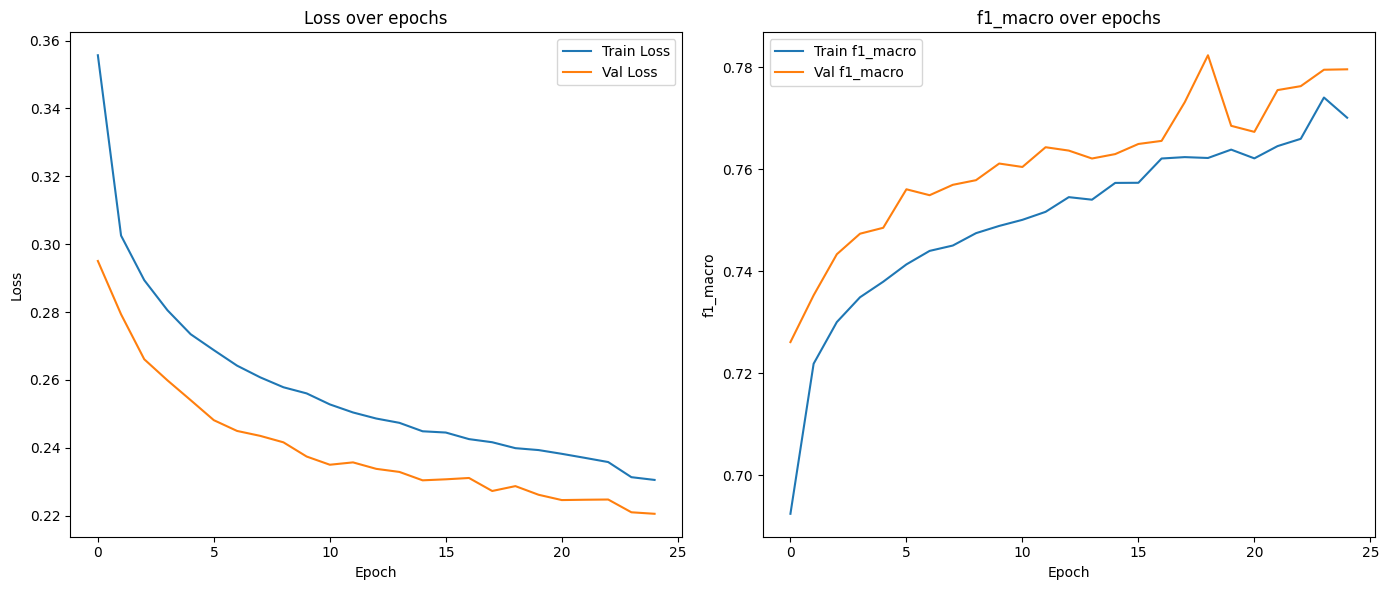

In [ ]:
# Параметры
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_data = pd.read_csv('test.csv')
batch_size = 32
num_epochs = 30
early_stop_rounds = 5
lr = 1e-3
dropout_rate = 0.3
hidden_sizes = [128, 64]

SELECTED_LOSS = 'bce'          # 'bce' или 'bce_logits'
SELECTED_METRIC = 'f1_macro'   # 'f1_macro', 'accuracy', 'roc_auc'

loss_function = LOSS_OPTIONS[SELECTED_LOSS]
eval_metric = METRIC_OPTIONS[SELECTED_METRIC]

# Загрузка и подготовка данных

def tokenize(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[\r\n\t]', ' ', text)
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

counter = Counter()
for text in train_cnn:
    counter.update(tokenize(text))

vocab = {"<pad>": 0, "<unk>": 1}
for idx, (word, freq) in enumerate(counter.items(), start=2):
    vocab[word] = idx

max_len = 100

def encode_and_pad(texts, vocab, max_len):
    encoded = []
    for text in texts:
        tokens = tokenize(text)
        indices = [vocab.get(token, vocab["<unk>"]) for token in tokens]
        indices = indices[:max_len]
        pad_len = max_len - len(indices)
        indices += [vocab["<pad>"]] * pad_len
        encoded.append(indices)
    return torch.tensor(encoded, dtype=torch.long)

X_train_pad = encode_and_pad(train_cnn, vocab, max_len)
X_val_pad = encode_and_pad(val_cnn, vocab, max_len)
X_test_pad = encode_and_pad(test_data['text'], vocab, max_len)

def labels_str_to_array(label_str):
    return np.array(list(map(int, label_str.strip().split())), dtype=np.float32)

y_train_array = np.stack(y_train_cnn.apply(labels_str_to_array).values)
y_val_array = np.stack(y_val_cnn.apply(labels_str_to_array).values)

X_train_tensor = X_train_pad.to(device)
X_val_tensor = X_val_pad.to(device)
X_test_tensor = X_test_pad.to(device)

y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_array, dtype=torch.float32).to(device)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# модель

class CNNText(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_sizes, num_classes, dropout_rate):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<pad>"])
        self.conv1 = nn.Conv1d(embed_dim, hidden_sizes[0], kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(dropout_rate)
        if len(hidden_sizes) > 1:
            self.fc1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
            self.fc2 = nn.Linear(hidden_sizes[1], num_classes)
        else:
            self.fc1 = None
            self.fc2 = nn.Linear(hidden_sizes[0], num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x).squeeze(2)
        x = self.dropout(x)
        if self.fc1 is not None:
            x = self.fc1(x)
            x = self.relu(x)
            x = self.dropout(x)
        x = self.fc2(x)
        if SELECTED_LOSS == 'bce':
            x = self.sigmoid(x)
        return x

vocab_size = len(vocab)
embed_dim = 100
num_classes = y_train_array.shape[1]

model = CNNText(vocab_size, embed_dim, hidden_sizes, num_classes, dropout_rate).to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

#Обучение

best_val_loss = float('inf')
best_epoch = 0
train_losses = []
val_losses = []
best_val_metric = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    all_train_preds = []
    all_train_labels = []

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = loss_function(outputs, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        all_train_preds.append(outputs.detach().cpu().numpy())
        all_train_labels.append(yb.detach().cpu().numpy())

    train_loss /= len(train_loader)

    train_preds_np = np.vstack(all_train_preds)
    train_labels_np = np.vstack(all_train_labels)

    train_metric = eval_metric(train_labels_np, train_preds_np)

    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            val_loss += loss_function(outputs, yb).item()

            all_val_preds.append(outputs.cpu().numpy())
            all_val_labels.append(yb.cpu().numpy())

    val_loss /= len(val_loader)

    val_preds_np = np.vstack(all_val_preds)
    val_labels_np = np.vstack(all_val_labels)

    val_metric = eval_metric(val_labels_np, val_preds_np)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Train {SELECTED_METRIC} = {train_metric:.4f}, Val {SELECTED_METRIC} = {val_metric:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_cnn_model.pt')

    elif epoch - best_epoch > early_stop_rounds:
        print("Early stopping")
        break

# предсказания

model.load_state_dict(torch.load('best_cnn_model.pt'))
model.eval()

def predictions_to_str(preds, threshold=0.5):
    return ' '.join([str(int(p >= threshold)) for p in preds])

all_preds = []
with torch.no_grad():
    for xb in test_loader:
        outputs = model(xb[0].to(device))
        if SELECTED_LOSS == 'bce_logits':
            outputs = torch.sigmoid(outputs)
        preds = outputs.cpu().numpy()
        for pred in preds:
            all_preds.append(predictions_to_str(pred))

results = pd.DataFrame({
    'id': test_data['id'],
    'labels': all_preds
})
results.to_csv('predictions_cnn.csv', index=False)

# Визуализация

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_metric_history, label=f'Train {SELECTED_METRIC}')
plt.plot(val_metric_history, label=f'Val {SELECTED_METRIC}')
plt.xlabel('Epoch')
plt.ylabel(SELECTED_METRIC)
plt.title(f'{SELECTED_METRIC} over epochs')
plt.legend()

plt.tight_layout()
plt.show()

встроенный эмбеддинг + RNN

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 Train loss: 0.5007 Val loss: 0.4879 Train f1_macro: 0.5734 Val f1_macro: 0.5760
Epoch 2/30 Train loss: 0.4920 Val loss: 0.4876 Train f1_macro: 0.5662 Val f1_macro: 0.5428
Epoch 3/30 Train loss: 0.4914 Val loss: 0.4878 Train f1_macro: 0.5661 Val f1_macro: 0.5428
Epoch 4/30 Train loss: 0.4908 Val loss: 0.4880 Train f1_macro: 0.5653 Val f1_macro: 0.5428
Epoch 5/30 Train loss: 0.4910 Val loss: 0.4878 Train f1_macro: 0.5651 Val f1_macro: 0.5760
Epoch 6/30 Train loss: 0.4907 Val loss: 0.4881 Train f1_macro: 0.5651 Val f1_macro: 0.5760
Epoch 7/30 Train loss: 0.4905 Val loss: 0.4879 Train f1_macro: 0.5643 Val f1_macro: 0.5760
Epoch 8/30 Train loss: 0.4905 Val loss: 0.4878 Train f1_macro: 0.5675 Val f1_macro: 0.5430
Epoch 9/30 Train loss: 0.4903 Val loss: 0.4876 Train f1_macro: 0.5649 Val f1_macro: 0.5435
Epoch 10/30 Train loss: 0.4897 Val loss: 0.4872 Train f1_macro: 0.5572 Val f1_macro: 0.5485
Epoch 11/30 Train loss: 0.4903 Val loss: 0.4879 Train f1_macro: 0.5641 Val f1_macro: 0.54

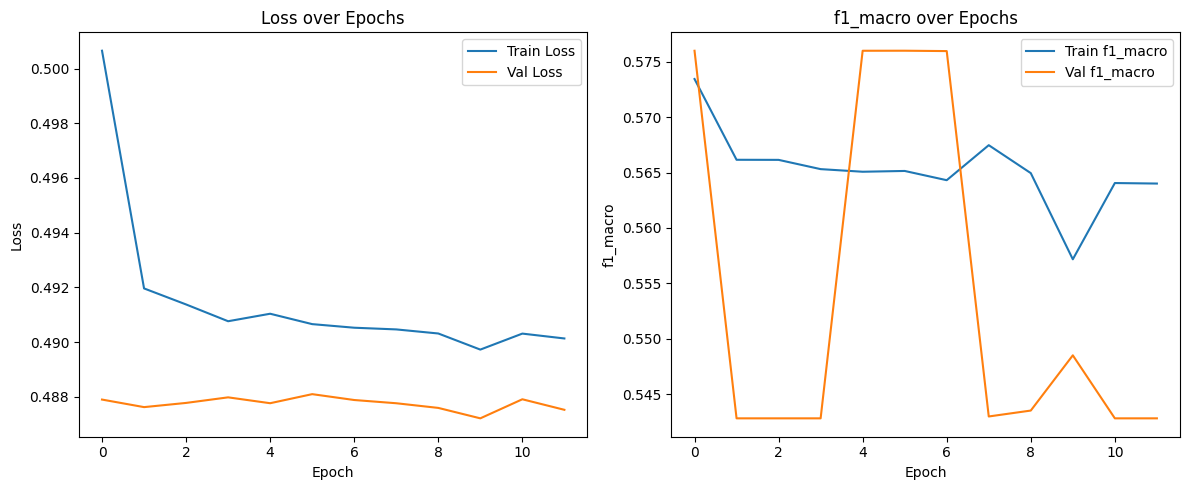

In [ ]:
# ПАРАМЕТРЫ
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_data = pd.read_csv('test.csv')
batch_size = 32
num_epochs = 30
early_stop_rounds = 5
lr = 0.001
dropout_rate = 0.3
hidden_sizes = [128, 64]

SELECTED_LOSS = 'bce_logits'   # 'bce' или 'bce_logits'
SELECTED_METRIC = 'f1_macro'   # 'accuracy', 'roc_auc', 'f1_macro'

def labels_str_to_array(label_str):
    return np.array(list(map(int, label_str.strip().split())), dtype=np.float32)

counter = Counter()
for text in pd.concat([train_rnn, val_rnn]):
    counter.update(text.split())

vocab = {word: idx + 1 for idx, (word, _) in enumerate(counter.items())}
vocab['<PAD>'] = 0

def text_to_indices(text, vocab):
    return torch.tensor([vocab.get(word, 0) for word in text.split()], dtype=torch.long)

X_train_idx = [text_to_indices(text, vocab) for text in train_rnn]
X_val_idx = [text_to_indices(text, vocab) for text in val_rnn]
X_test_idx = [text_to_indices(text, vocab) for text in test_data['text']]

X_train_padded = pad_sequence(X_train_idx, batch_first=True, padding_value=0)
X_val_padded = pad_sequence(X_val_idx, batch_first=True, padding_value=0)
X_test_padded = pad_sequence(X_test_idx, batch_first=True, padding_value=0)

y_train_array = np.stack(y_train_rnn.apply(labels_str_to_array).values)
y_val_array = np.stack(y_val_rnn.apply(labels_str_to_array).values)

X_train_tensor = X_train_padded.to(device)
X_val_tensor = X_val_padded.to(device)
X_test_tensor = X_test_padded.to(device)

y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_array, dtype=torch.float32).to(device)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Модель
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_sizes, num_classes, dropout_rate=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_sizes[0], batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Sequential(
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_sizes[1], num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        h_n = h_n.squeeze(0)
        h_n = self.dropout(h_n)
        out = self.fc(h_n)
        return out

num_classes = y_train_array.shape[1]
vocab_size = len(vocab)
embed_dim = 100

model = RNNModel(vocab_size, embed_dim, hidden_sizes, num_classes, dropout_rate).to(device)

if SELECTED_LOSS == 'bce_logits':
    criterion = nn.BCEWithLogitsLoss()
elif SELECTED_LOSS == 'bce':
    criterion = nn.BCELoss()
else:
    raise ValueError("Unknown loss selected")

# Оптимизатор и scheduler
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)

def compute_metric(y_true, y_pred_logits, threshold=0.5):
    if SELECTED_LOSS == 'bce_logits':
        y_pred = torch.sigmoid(y_pred_logits).cpu().numpy()
    else:
        y_pred = y_pred_logits.cpu().numpy()
    y_true = y_true.cpu().numpy()

    y_pred_bin = (y_pred >= threshold).astype(int)

    if SELECTED_METRIC == 'f1_macro':
        return f1_score(y_true, y_pred_bin, average='macro')
    elif SELECTED_METRIC == 'accuracy':
        return accuracy_score(y_true, y_pred_bin)
    elif SELECTED_METRIC == 'roc_auc':
        try:
            return roc_auc_score(y_true, y_pred)
        except ValueError:
            return 0.0
    else:
        raise ValueError("Unknown metric selected")

# обучение
best_val_metric = -np.inf
best_epoch = -1

train_losses = []
val_losses = []
train_metrics = []
val_metrics = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    all_train_preds = []
    all_train_targets = []

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() * xb.size(0)

        all_train_preds.append(outputs.detach())
        all_train_targets.append(yb.detach())

    epoch_train_loss /= len(train_loader.dataset)

    train_preds_tensor = torch.cat(all_train_preds)
    train_targets_tensor = torch.cat(all_train_targets)
    train_metric = compute_metric(train_targets_tensor, train_preds_tensor)

    model.eval()
    epoch_val_loss = 0
    all_val_preds = []
    all_val_targets = []
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            loss = criterion(outputs, yb)
            epoch_val_loss += loss.item() * xb.size(0)

            all_val_preds.append(outputs)
            all_val_targets.append(yb)
    epoch_val_loss /= len(val_loader.dataset)
    val_preds_tensor = torch.cat(all_val_preds)
    val_targets_tensor = torch.cat(all_val_targets)
    val_metric = compute_metric(val_targets_tensor, val_preds_tensor)

    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_metrics.append(train_metric)
    val_metrics.append(val_metric)

    print(f"Epoch {epoch+1}/{num_epochs} Train loss: {epoch_train_loss:.4f} Val loss: {epoch_val_loss:.4f} "
          f"Train {SELECTED_METRIC}: {train_metric:.4f} Val {SELECTED_METRIC}: {val_metric:.4f}")

    scheduler.step(epoch_val_loss)

    if val_metric > best_val_metric:
        best_val_metric = val_metric
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_rnn_model.pt')
    elif epoch - best_epoch > early_stop_rounds:
        print("Early stopping")
        break

# Предсказания
model.load_state_dict(torch.load('best_rnn_model.pt'))
model.eval()

def predictions_to_str(preds, threshold=0.5):
    preds = preds.cpu().numpy()
    bin_preds = (preds >= threshold).astype(int)
    return ' '.join(map(str, bin_preds))

all_preds = []
with torch.no_grad():
    for xb in test_loader:
        outputs = model(xb[0].to(device))
        if SELECTED_LOSS == 'bce_logits':
            outputs = torch.sigmoid(outputs)
        for pred in outputs:
            all_preds.append(predictions_to_str(pred))

results = pd.DataFrame({
    'id': test_data['id'],
    'labels': all_preds
})
results.to_csv('predictions_rnn.csv', index=False)
print("Предсказания сохранены в predictions_rnn.csv")

# Визуализация
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1,2,2)
plt.plot(train_metrics, label=f'Train {SELECTED_METRIC}')
plt.plot(val_metrics, label=f'Val {SELECTED_METRIC}')
plt.xlabel('Epoch')
plt.ylabel(SELECTED_METRIC)
plt.legend()
plt.title(f'{SELECTED_METRIC} over Epochs')

plt.tight_layout()
plt.show()


эмбеддинг + BERT-like модель

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_losses = []
val_losses = []
train_metric_history = []
val_metric_history = []

SELECTED_METRIC = 'f1_macro'  # Или 'accuracy', 'roc_auc'
metric_fn = METRIC_OPTIONS[SELECTED_METRIC]

def get_random_embedding(num_samples, emb_size):
    return torch.randn(num_samples, emb_size)

# emb_size = 32
emb_size = 32

# Токенизация BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def bert_encode(texts, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

train_texts = train_bert
val_texts = val_bert
test_texts = test_data['text']

X_train_input_ids, X_train_attention_masks = bert_encode(train_texts, tokenizer)
X_val_input_ids, X_val_attention_masks = bert_encode(val_texts, tokenizer)
X_test_input_ids, X_test_attention_masks = bert_encode(test_texts, tokenizer)

# Доп. эмбеддинги для каждого набора
X_train_add_emb = get_random_embedding(len(train_texts), emb_size)
X_val_add_emb = get_random_embedding(len(val_texts), emb_size)
X_test_add_emb = get_random_embedding(len(test_texts), emb_size)

# Метки
def labels_str_to_array(label_str):
    return np.array(list(map(int, label_str.strip().split())), dtype=np.float32)

y_train_array = np.stack(y_train_bert.apply(labels_str_to_array).values)
y_val_array = np.stack(y_val_bert.apply(labels_str_to_array).values)

X_train_input_ids = X_train_input_ids.to(device)
X_train_attention_masks = X_train_attention_masks.to(device)
X_val_input_ids = X_val_input_ids.to(device)
X_val_attention_masks = X_val_attention_masks.to(device)
X_test_input_ids = X_test_input_ids.to(device)
X_test_attention_masks = X_test_attention_masks.to(device)

X_train_add_emb = X_train_add_emb.to(device)
X_val_add_emb = X_val_add_emb.to(device)
X_test_add_emb = X_test_add_emb.to(device)

y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_array, dtype=torch.float32).to(device)

train_ds = TensorDataset(X_train_input_ids, X_train_attention_masks, X_train_add_emb, y_train_tensor)
val_ds = TensorDataset(X_val_input_ids, X_val_attention_masks, X_val_add_emb, y_val_tensor)
test_ds = TensorDataset(X_test_input_ids, X_test_attention_masks, X_test_add_emb)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

# Модель с объединением BERT и доп. эмбеддинга
class BERTPlusEmbeddingModel(nn.Module):
    def __init__(self, num_classes, additional_emb_size):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        bert_hidden_size = self.bert.config.hidden_size

        self.fc = nn.Sequential(
            nn.Linear(bert_hidden_size + additional_emb_size, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask, additional_emb):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output

        combined = torch.cat((pooled_output, additional_emb), dim=1)
        out = self.fc(combined)
        return out

num_classes = y_train_array.shape[1]
model = BERTPlusEmbeddingModel(num_classes, emb_size).to(device)

# Обучение
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

early_stop_patience = 5
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(10):
    model.train()
    train_loss = 0.0
    for input_ids, attention_mask, add_emb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, add_emb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_targets = []

    with torch.no_grad():
        for input_ids, attention_mask, add_emb, yb in val_loader:
            outputs = model(input_ids, attention_mask, add_emb)
            loss = criterion(outputs, yb)
            val_loss += loss.item()

            all_val_preds.append(outputs.cpu().numpy())
            all_val_targets.append(yb.cpu().numpy())

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Метрики
    model.eval()
    all_train_preds = []
    all_train_targets = []
    with torch.no_grad():
        for input_ids, attention_mask, add_emb, yb in train_loader:
            outputs = model(input_ids, attention_mask, add_emb)
            all_train_preds.append(outputs.cpu().numpy())
            all_train_targets.append(yb.cpu().numpy())

    all_train_preds = np.vstack(all_train_preds)
    all_train_targets = np.vstack(all_train_targets)
    train_metric = metric_fn(all_train_targets, all_train_preds)

    all_val_preds = np.vstack(all_val_preds)
    all_val_targets = np.vstack(all_val_targets)
    val_metric = metric_fn(all_val_targets, all_val_preds)

    train_metric_history.append(train_metric)
    val_metric_history.append(val_metric)

    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train {SELECTED_METRIC}: {train_metric:.4f}, Val {SELECTED_METRIC}: {val_metric:.4f}')

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_bert_plus_emb_model.pt')
        best_epoch = epoch
    else:
        if epoch - best_epoch > early_stop_patience:
            print("Early stopping")
            break

# Предсказания
model.load_state_dict(torch.load('best_bert_plus_emb_model.pt'))
model.eval()

def predictions_to_str(preds, threshold=0.5):
    return ' '.join([str(int(p >= threshold)) for p in preds])

all_preds = []
with torch.no_grad():
    for input_ids, attention_mask, add_emb in test_loader:
        outputs = model(input_ids.to(device), attention_mask.to(device), add_emb.to(device))
        preds = outputs.cpu().numpy()
        for pred in preds:
            all_preds.append(predictions_to_str(pred))

results = pd.DataFrame({
    'id': test_data['id'],
    'labels': all_preds
})
results.to_csv('predictions_bert_plus_emb.csv', index=False)
print("Предсказания сохранены в predictions_bert_plus_emb.csv")

# Визуализация
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Loss по эпохам')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_metric_history, label=f'Train {SELECTED_METRIC}')
plt.plot(val_metric_history, label=f'Val {SELECTED_METRIC}')
plt.xlabel('Эпоха')
plt.ylabel(SELECTED_METRIC)
plt.title(f'{SELECTED_METRIC} по эпохам')
plt.legend()

plt.tight_layout()
plt.show()



Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1: Train Loss: 0.4087, Val Loss: 0.3387, Train f1_macro: 0.6837, Val f1_macro: 0.6836


## СКОР С КАГГЛА (встроенный эмбеддинг + CNN)

Epoch 1: Train Loss: 0.4189, Val Loss: 0.2611, Train F1-macro: 0.6712, Val F1-macro: 0.7487
Epoch 2: Train Loss: 0.3026, Val Loss: 0.2337, Train F1-macro: 0.7277, Val F1-macro: 0.7787
Epoch 3: Train Loss: 0.2708, Val Loss: 0.2199, Train F1-macro: 0.7437, Val F1-macro: 0.7897
Epoch 4: Train Loss: 0.2461, Val Loss: 0.2085, Train F1-macro: 0.7607, Val F1-macro: 0.7807
Epoch 5: Train Loss: 0.2288, Val Loss: 0.1984, Train F1-macro: 0.7718, Val F1-macro: 0.7946
Epoch 6: Train Loss: 0.2162, Val Loss: 0.1917, Train F1-macro: 0.7806, Val F1-macro: 0.7988
Epoch 7: Train Loss: 0.2061, Val Loss: 0.1903, Train F1-macro: 0.7929, Val F1-macro: 0.7981
Epoch 8: Train Loss: 0.1986, Val Loss: 0.1876, Train F1-macro: 0.7955, Val F1-macro: 0.8066
Epoch 9: Train Loss: 0.1952, Val Loss: 0.1842, Train F1-macro: 0.7970, Val F1-macro: 0.8038
Epoch 10: Train Loss: 0.1920, Val Loss: 0.1837, Train F1-macro: 0.7991, Val F1-macro: 0.8037
Epoch 11: Train Loss: 0.1915, Val Loss: 0.1848, Train F1-macro: 0.7978, Val F1-

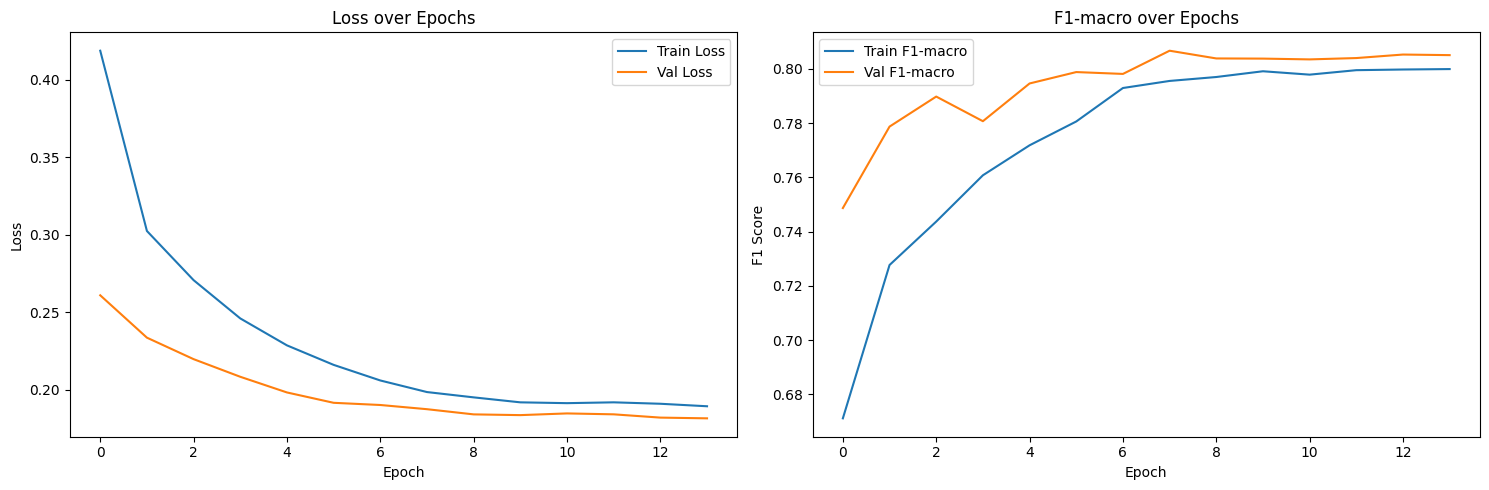

Best threshold: 0.30, Best F1: 0.8157
Predictions saved to predictions_cnn.csv


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_data = pd.read_csv('test.csv')

def synonym_replacement(text, n=2):
    words = text.split()
    if len(words) < 2:
        return text
    for _ in range(n):
        idx = random.randint(0, len(words) - 1)
        words[idx] = words[idx][::-1]
    return ' '.join(words)

def random_deletion(text, p=0.1):
    words = text.split()
    if len(words) == 1:
        return text
    new_words = [word for word in words if random.random() > p]
    if not new_words:
        new_words = [random.choice(words)]
    return ' '.join(new_words)

def tokenize(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[\r\n\t]', ' ', text)
    return re.findall(r'\b\w+\b', text)

counter = Counter()
augmented_train = train_cnn.apply(lambda x: synonym_replacement(x))
augmented_train = augmented_train.apply(lambda x: random_deletion(x))
for text in pd.concat([train_cnn, augmented_train]):
    counter.update(tokenize(text))

vocab = {"<pad>": 0, "<unk>": 1}
for idx, (word, freq) in enumerate(counter.items(), start=2):
    vocab[word] = idx

max_len = 200

def encode_and_pad(texts, vocab, max_len):
    encoded = []
    for text in texts:
        tokens = tokenize(text)
        indices = [vocab.get(token, vocab["<unk>"]) for token in tokens][:max_len]
        indices += [vocab["<pad>"]] * (max_len - len(indices))
        encoded.append(indices)
    return torch.tensor(encoded, dtype=torch.long)

X_train_pad = encode_and_pad(train_cnn, vocab, max_len)
X_val_pad = encode_and_pad(val_cnn, vocab, max_len)
X_test_pad = encode_and_pad(test_data['text'], vocab, max_len)

def labels_str_to_array(label_str):
    return np.array(list(map(int, label_str.strip().split())), dtype=np.float32)

y_train_array = np.stack(y_train_cnn.apply(labels_str_to_array).values)
y_val_array = np.stack(y_val_cnn.apply(labels_str_to_array).values)

X_train_tensor = X_train_pad.to(device)
X_val_tensor = X_val_pad.to(device)
X_test_tensor = X_test_pad.to(device)

y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_array, dtype=torch.float32).to(device)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Модель CNN
class CNNTextAdvanced(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<pad>"])
        self.embedding_dropout = nn.Dropout(0.3)
        self.conv1 = nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(embed_dim, 128, kernel_size=4, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(embed_dim, 128, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128 * 3, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.embedding_dropout(x)
        x = x.permute(0, 2, 1)
        x1 = self.pool(self.relu(self.bn1(self.conv1(x)))).squeeze(2)
        x2 = self.pool(self.relu(self.bn2(self.conv2(x)))).squeeze(2)
        x3 = self.pool(self.relu(self.bn3(self.conv3(x)))).squeeze(2)
        x = torch.cat([x1, x2, x3], dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

embed_dim = 300
num_classes = y_train_array.shape[1]
model = CNNTextAdvanced(len(vocab), embed_dim, num_classes).to(device)

# Обучение
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

early_stop_patience = 5
best_val_loss = float('inf')
best_val_f1 = 0
train_losses, val_losses = [], []
train_f1s, val_f1s = [], []

for epoch in range(30):
    model.train()
    train_loss = 0.0
    train_preds, train_true = [], []

    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_preds.append(torch.sigmoid(outputs).cpu().detach().numpy())
        train_true.append(yb.cpu().numpy())

    model.eval()
    val_loss = 0.0
    val_preds, val_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            val_loss += criterion(outputs, yb).item()
            val_preds.append(torch.sigmoid(outputs).cpu().numpy())
            val_true.append(yb.cpu().numpy())


    train_loss /= len(train_loader)
    val_loss /= len(val_loader)

    train_preds_bin = (np.vstack(train_preds) >= 0.5).astype(int)
    train_f1 = f1_score(np.vstack(train_true), train_preds_bin, average='macro')

    val_preds_bin = (np.vstack(val_preds) >= 0.5).astype(int)
    val_f1 = f1_score(np.vstack(val_true), val_preds_bin, average='macro')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train F1-macro: {train_f1:.4f}, Val F1-macro: {val_f1:.4f}')

    scheduler.step()

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_cnn_model.pt')
        best_epoch = epoch
    elif epoch - best_epoch > early_stop_patience:
        print("Early stopping triggered")
        break

# Визуализация
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_f1s, label='Train F1-macro')
plt.plot(val_f1s, label='Val F1-macro')
plt.title('F1-macro over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

# Подбор оптимального порога
model.load_state_dict(torch.load('best_cnn_model.pt'))
model.eval()

val_preds, val_true = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        outputs = model(xb)
        val_preds.append(torch.sigmoid(outputs).cpu().numpy())
        val_true.append(yb.cpu().numpy())

val_preds = np.vstack(val_preds)
val_true = np.vstack(val_true)

thresholds = np.arange(0.1, 0.9, 0.05)
best_thr, best_f1 = 0.5, 0
for thr in thresholds:
    preds_bin = (val_preds >= thr).astype(int)
    f1 = f1_score(val_true, preds_bin, average='macro')
    if f1 > best_f1:
        best_f1, best_thr = f1, thr

print(f'Best threshold: {best_thr:.2f}, Best F1: {best_f1:.4f}')

# Предсказания
model.eval()
all_preds = []
with torch.no_grad():
    for xb in test_loader:
        outputs = model(xb[0].to(device))
        preds = torch.sigmoid(outputs).cpu().numpy()
        for pred in preds:
            all_preds.append(' '.join([str(int(p >= best_thr)) for p in pred]))

results = pd.DataFrame({'id': test_data['id'], 'labels': all_preds})
results.to_csv('predictions_cnn.csv', index=False)
print("Predictions saved to predictions_cnn.csv")

## 4 ПУНКТ: Запросить у модели декодер сгенерировать примеры с тем же распределением меток, что и у данных. Обогатить этими данными датасет (добавить хотя бы 1000 наблюдений). Проверить свой лучший пайплайн на улучшение/уменьшение качества модели вместе со сгенерированными данными. Сделать выводы и объяснить результат.

Epoch 1: Train F1=0.6719, Val F1=0.7317
Epoch 2: Train F1=0.7257, Val F1=0.7625
Epoch 3: Train F1=0.7527, Val F1=0.7777
Epoch 4: Train F1=0.7613, Val F1=0.7850
Epoch 5: Train F1=0.7729, Val F1=0.7899
Epoch 6: Train F1=0.7793, Val F1=0.7922
Epoch 7: Train F1=0.7830, Val F1=0.7942
Epoch 8: Train F1=0.7908, Val F1=0.7984
Epoch 9: Train F1=0.7902, Val F1=0.7958
Epoch 10: Train F1=0.7961, Val F1=0.7981
Epoch 11: Train F1=0.7926, Val F1=0.7983
Epoch 12: Train F1=0.7956, Val F1=0.7970
Epoch 13: Train F1=0.7958, Val F1=0.8018
Epoch 14: Train F1=0.7977, Val F1=0.8016
Epoch 15: Train F1=0.7958, Val F1=0.8010
Epoch 16: Train F1=0.7985, Val F1=0.8171
Epoch 17: Train F1=0.8028, Val F1=0.8014
Epoch 18: Train F1=0.8050, Val F1=0.8082
Epoch 19: Train F1=0.8139, Val F1=0.8031
Epoch 20: Train F1=0.8189, Val F1=0.8187
Epoch 21: Train F1=0.8186, Val F1=0.8212
Epoch 22: Train F1=0.8302, Val F1=0.8257
Epoch 23: Train F1=0.8423, Val F1=0.8325
Epoch 24: Train F1=0.8371, Val F1=0.8373
Epoch 25: Train F1=0.8475

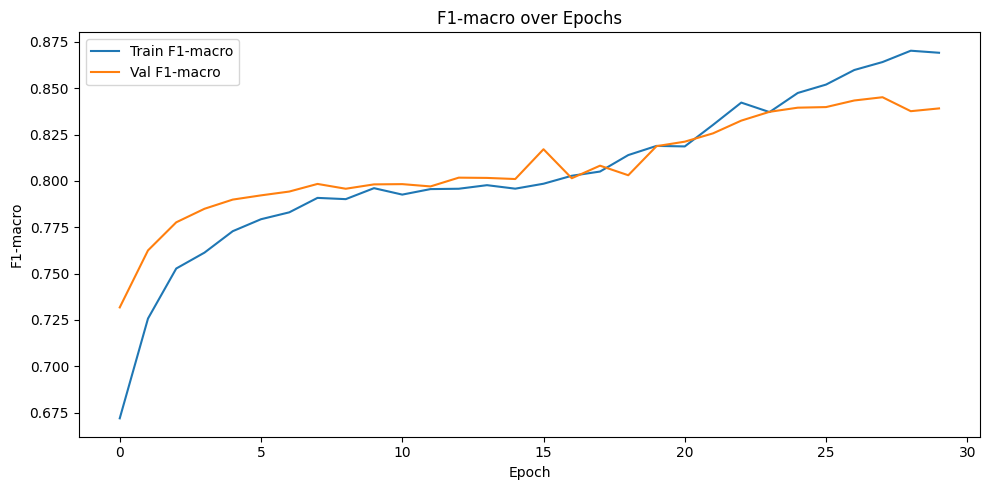

In [16]:
# Параметры
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 32
num_epochs = 30
early_stop_rounds = 5
lr = 1e-3
embed_dim = 300
max_len = 200

def synonym_replacement(text, n=2):
    words = text.split()
    if len(words) < 2:
        return text
    for _ in range(n):
        idx = random.randrange(len(words))
        words[idx] = words[idx][::-1]
    return " ".join(words)

def random_deletion(text, p=0.1):
    words = text.split()
    if len(words) == 1:
        return text
    new_words = [w for w in words if random.random() > p]
    return " ".join(new_words) if new_words else random.choice(words)

def tokenize(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[\r\n\t]', ' ', text)
    return re.findall(r'\b\w+\b', text)

def labels_str_to_array(label_str):
    return np.array(list(map(int, label_str.strip().split())), dtype=np.float32)

def encode_and_pad(texts, vocab, max_len):
    encoded = []
    for text in texts:
        toks = tokenize(text)
        idxs = [vocab.get(t, vocab["<unk>"]) for t in toks][:max_len]
        idxs += [vocab["<pad>"]] * (max_len - len(idxs))
        encoded.append(idxs)
    return torch.tensor(encoded, dtype=torch.long)

train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

orig_labels = np.stack(train_df["labels"].apply(labels_str_to_array).values)
freq = orig_labels.mean(axis=0)

n_synth = 1000
synth_texts, synth_labels = [], []
for _ in range(n_synth):
    vec = (np.random.rand(orig_labels.shape[1]) < freq).astype(int)
    if vec.sum() == 0:
        vec[random.randrange(len(vec))] = 1
    txt = random.choice(train_df["text"].tolist())
    new_txt = random_deletion(synonym_replacement(txt))
    synth_texts.append(new_txt)
    synth_labels.append(" ".join(map(str, vec)))

synth_df = pd.DataFrame({"text": synth_texts, "labels": synth_labels})

aug_df = pd.concat([train_df[["text","labels"]], synth_df], ignore_index=True)

label_counts = aug_df["labels"].value_counts()
filtered_df = aug_df[aug_df["labels"].isin(label_counts[label_counts >= 2].index)]

train_texts, val_texts, train_lbls, val_lbls = train_test_split(
    filtered_df["text"], filtered_df["labels"], test_size=0.2, stratify=filtered_df["labels"])

counter = Counter()
for t in pd.concat([train_texts, val_texts]):
    counter.update(tokenize(t))
vocab = {"<pad>":0, "<unk>":1}
for i,(w,_) in enumerate(counter.items(), start=2):
    vocab[w] = i

X_train = encode_and_pad(train_texts, vocab, max_len)
X_val   = encode_and_pad(val_texts,   vocab, max_len)
X_test  = encode_and_pad(test_df["text"], vocab, max_len)

y_train = np.stack(train_lbls.apply(labels_str_to_array).values)
y_val   = np.stack(val_lbls.apply(labels_str_to_array).values)

train_ds = TensorDataset(X_train.to(device), torch.tensor(y_train, dtype=torch.float32).to(device))
val_ds   = TensorDataset(X_val.to(device),   torch.tensor(y_val,   dtype=torch.float32).to(device))
test_ds  = TensorDataset(X_test.to(device))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)
test_loader  = DataLoader(test_ds,  batch_size=batch_size)

# модель
class CNNTextAdvanced(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<pad>"])
        self.drop_e = nn.Dropout(0.3)
        self.conv1 = nn.Conv1d(embed_dim,128,3,padding=1)
        self.bn1   = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(embed_dim,128,4,padding=2)
        self.bn2   = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(embed_dim,128,5,padding=2)
        self.bn3   = nn.BatchNorm1d(128)
        self.relu  = nn.ReLU()
        self.pool  = nn.AdaptiveMaxPool1d(1)
        self.drop  = nn.Dropout(0.5)
        self.fc    = nn.Linear(128*3, num_classes)
    def forward(self,x):
        x = self.embed(x)
        x = self.drop_e(x)
        x = x.permute(0,2,1)
        x1 = self.pool(self.relu(self.bn1(self.conv1(x)))).squeeze(2)
        x2 = self.pool(self.relu(self.bn2(self.conv2(x)))).squeeze(2)
        x3 = self.pool(self.relu(self.bn3(self.conv3(x)))).squeeze(2)
        x = torch.cat([x1,x2,x3],1)
        x = self.drop(x)
        return self.fc(x)

num_classes = y_train.shape[1]
model = CNNTextAdvanced(len(vocab), embed_dim, num_classes).to(device)

# Обучение и валидация
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

best_val_f1 = 0
best_epoch = 0
train_f1s, val_f1s = [], []

for epoch in range(num_epochs):
    model.train()
    preds_tr, true_tr = [], []
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        preds_tr.append(torch.sigmoid(out).detach().cpu().numpy())
        true_tr.append(yb.cpu().numpy())

    model.eval()
    preds_val, true_val = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            out = model(xb)
            preds_val.append(torch.sigmoid(out).cpu().numpy())
            true_val.append(yb.cpu().numpy())

    train_f1 = f1_score(np.vstack(true_tr), (np.vstack(preds_tr)>=0.5).astype(int), average="macro")
    val_f1   = f1_score(np.vstack(true_val), (np.vstack(preds_val)>=0.5).astype(int), average="macro")
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}: Train F1={train_f1:.4f}, Val F1={val_f1:.4f}")

    scheduler.step()
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_epoch = epoch
        torch.save(model.state_dict(), "best_cnn_aug.pt")
    elif epoch - best_epoch > early_stop_rounds:
        print("Early stopping")
        break

# Сравнение результатов
print(f"Best Validation F1 after augmentation: {best_val_f1:.4f}")

# Визуализация
plt.figure(figsize=(10,5))
plt.plot(train_f1s, label="Train F1-macro")
plt.plot(val_f1s,   label="Val F1-macro")
plt.xlabel("Epoch")
plt.ylabel("F1-macro")
plt.title("F1-macro over Epochs")
plt.legend()
plt.tight_layout()
plt.show()

После добавления наблюдений можно сравнить результаты моделей:

Best Validation F1 F1: 0.8157
Best Validation F1 after augmentation: 0.8451

Таким образом, результат чуть улучшился.